# Notebook used for creating graphics and testing functions developed in the iib-neuro-proj library

In [1]:
import numpy as np
import time
import progressbar
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import truncexpon
from utils import *
from gen_inputs import *
from functs_inputs import *
from sim_hLN import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False

### Generate some 'realisitc' inputs

[15.  0. 15.  0. 15.  2.  1. 15. 13. 13. 14.  0. 15. 15.  0.  1.]
orientation 0 finished
orientation 1 finished
orientation 2 finished
orientation 3 finished
orientation 4 finished
orientation 5 finished
orientation 6 finished
orientation 7 finished
orientation 8 finished
orientation 9 finished
orientation 10 finished
orientation 11 finished
orientation 12 finished
orientation 13 finished
orientation 14 finished
orientation 15 finished
Excitatory spikes shape: (186772, 2) Inhibitory spikes shape: (121206, 2)


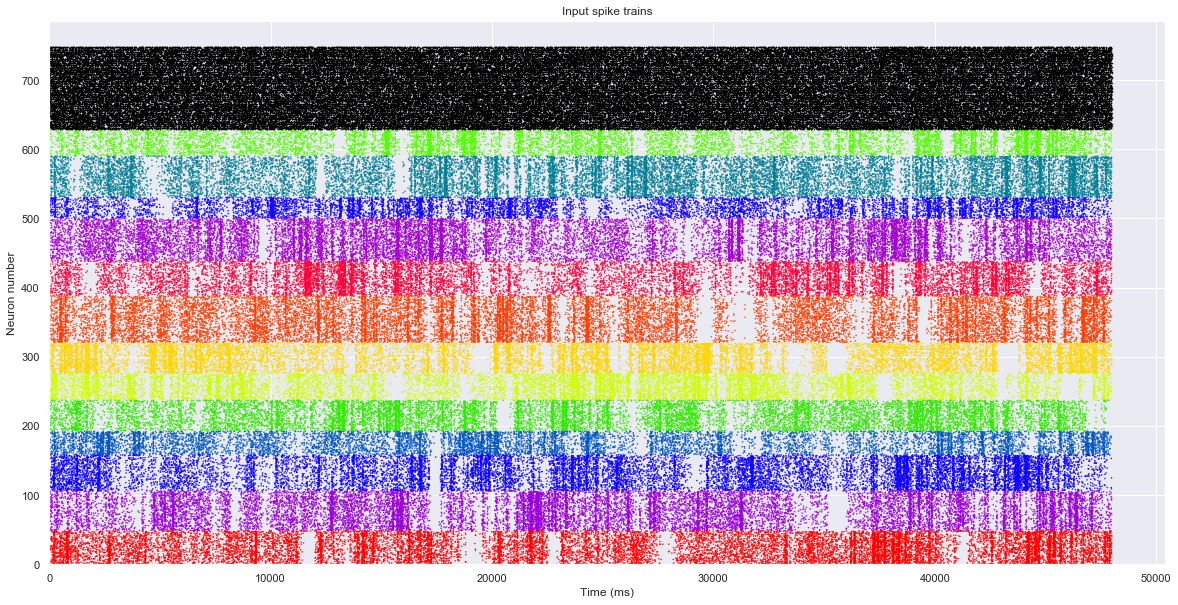

In [2]:
E_spikes, I_spikes = gen_realistic_inputs(Tmax=3000)
print("Excitatory spikes shape:", E_spikes.shape, "Inhibitory spikes shape:", I_spikes.shape)

Ensyn = [48, 58, 52, 34, 45, 39, 44, 68, 50, 62, 30, 60, 39]
Ensyn_cum = np.cumsum(Ensyn)
Ensyn_cum = Ensyn_cum.reshape(13, 1)
ens_num = np.argmax(Ensyn_cum > E_spikes[:, 0] - 1, axis=0)

plt.figure(figsize=(20,10))
plt.scatter(E_spikes[:, 1], E_spikes[:, 0], s=1, c=ens_num, cmap="prism", marker='.', label="Excitatory")
plt.scatter(I_spikes[:, 1], np.sum(Ensyn) + I_spikes[:, 0], s=1, marker='.', color='black', label='Inhibitory')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron number")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.title("Input spike trains")
plt.show()

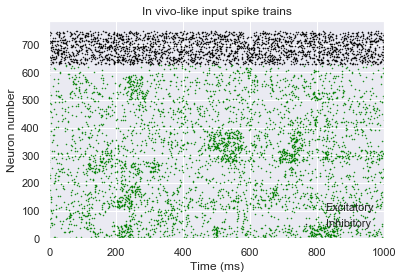

In [3]:
# plt.figure(figsize=(20,10))
plt.scatter(E_spikes[:, 1], E_spikes[:, 0], s=1, color='green', marker='.', label="Excitatory")
plt.scatter(I_spikes[:, 1], np.sum(Ensyn) + I_spikes[:, 0], s=1, marker='.', color='black', label='Inhibitory')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron number")
plt.ylim(bottom=0)
plt.xlim(left=0, right=1000)
plt.title("In vivo-like input spike trains")
plt.legend(loc="lower right")
# plt.savefig("inputs_short.png")
plt.show()

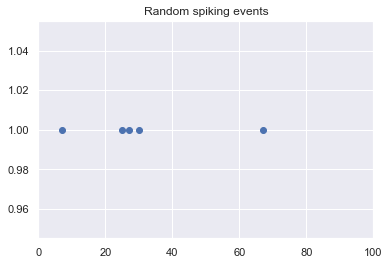

In [4]:
N = 100 # number of time bins
samp = binary_input(1, N, kind='rand')
times = np.arange(0, N, 1)
spikes = np.where(samp==0, np.nan, samp)
plt.plot(times, spikes.T, 'o')
plt.title("Random spiking events")
plt.xlim(0, N)
plt.show()

(1, 100)


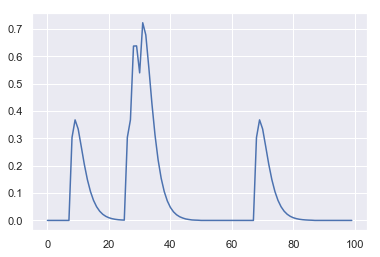

In [5]:
# show alpha filt works
conv = alpha_filt(tau=2, spikes=samp)
print(conv.shape)
plt.plot(times, conv.T)
plt.show()

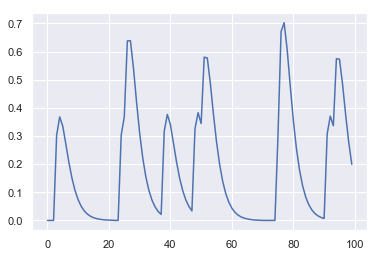

(100,)


In [6]:
# show int_spikes works
samp_2d = binary_input(2, N, kind='rand')
conv_int = int_spikes(X=samp_2d, dt=1, Wc=[0, 1], Ww=[1, -1], Tau=2, delay=0)
plt.plot(times, conv_int.T)
plt.show()
print(conv_int.shape)

In [7]:
# input realistic inputs to model
X_e = spikes_to_input(E_spikes, Tmax=48000)
X_i = spikes_to_input(I_spikes, Tmax=48000)
X_tot = np.vstack((X_e, X_i))

# number of excitatory, inhibitory neurons by ensemble
Ensyn = [48, 58, 52, 34, 45, 39, 44, 68, 50, 62, 30, 60, 39]
Insyn = [11, 11, 9, 6, 8, 5, 8, 12, 11, 13, 6, 11, 8]

N_e, N_i = np.sum(Ensyn), np.sum(Insyn)
N_soma = N_e + 1 #index of soma row in X_tot - might want to weight these inputs differently

# these parameters for 1 subunit
Jc_sing = np.array([0])
M=len(Jc_sing)
Jw_sing = np.full([M,1], 1) #coupling weights 1 for all branches intially
M = len(Jc_sing) #number of subunits
Wce_sing = [np.arange(0, X_e.shape[0], 1)] #all input excitatory neurons connected to root subunit
Wwe_sing = [np.ones(X_e.shape[0])] #weighting matrix - all excitatory neurons connected with weight 1 
Wci_sing = [np.arange(N_soma, N_soma + X_i.shape[0] -1, 1)] #all input inhibitory neurons connected to root subunit
Wwi_sing = [np.full(X_i.shape[0], -1)] #weighting matrix - all inhibitory neurons connected with weight -1
Tau_e = [np.full(X_e.shape[0], 1)] #all excitatory time constants 1
Tau_i = [np.full(X_i.shape[0], 1)] #all inhibitory time constants 1
Th = [1] #no offset in all sigmoids



resp_sing = sim_hLN(X=X_tot, dt=1, Jc=Jc_sing, Jw=Jw_sing, Wce=Wce_sing, Wwe=Wwe_sing, Wci=Wci_sing, Wwi=Wwi_sing, Tau_e=Tau_e, Tau_i=Tau_i, Th=Th, mult_inputs=True)





[1.]


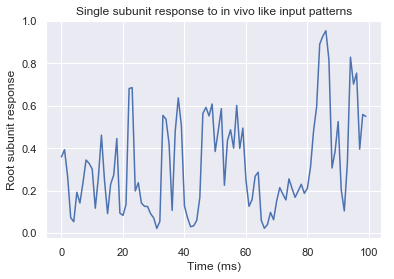

In [8]:
plt.plot(resp_sing[4900:5000])
plt.title("Single subunit response to in vivo like input patterns")
plt.xlabel("Time (ms)")
plt.ylabel("Root subunit response")
# plt.savefig("Jc_1_potential.png")
plt.show()

In [ ]:
# now parameters for 2 layer, 3 subunit model 
# all excitatory inputs to 1 subunit, all inhibitory to other unit in outer layer, then combine at root subunit 
Jc_2 = np.array([0, 1, 1])
M_2 = len(Jc_2) #number of subunits
Jw_2 = np.full([M_2,1], 1) #coupling weights 1 for all branches intially


Wce_2 = [[], np.arange(0, X_e.shape[0], 1), []] #all input excitatory neurons connected to subunit 2
Wwe_2 = [[], np.ones(X_e.shape[0]), []] #weighting matrix - all excitatory neurons connected with weight 1 
Wci_2 = [[], [], np.arange(N_soma, N_soma + X_i.shape[0] -1, 1)] #all input inhibitory neurons connected to subunit 3
Wwi_2 = [[], [], np.full(X_i.shape[0], -1)] #weighting matrix - all inhibitory neurons connected with weight -1
Tau_e2 = [[], np.full(X_e.shape[0], 1), []] #all excitatory time constants 1
Tau_i2 = [[], [], np.full(X_i.shape[0], 1)] #all inhibitory time constants 1
Th_2 = [0, -1, 1] #no offset in all sigmoids

resp_2 = sim_hLN(X=X_tot, dt=1, Jc=Jc_2, Jw=Jw_2, Wce=Wce_2, Wwe=Wwe_2, Wci=Wci_2, Wwi=Wwi_2, Tau_e=Tau_e2, Tau_i=Tau_i2, Th=Th_2, mult_inputs=True)


[2.]
[2. 3.]
[2. 3. 1.]


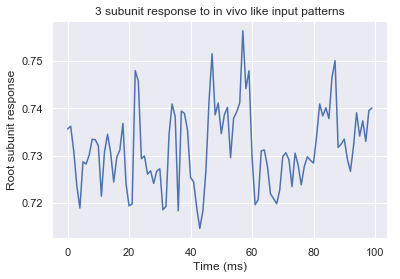

In [ ]:
plt.plot(resp_2[4900:5000])
plt.title("3 subunit response to in vivo like input patterns")
plt.xlabel("Time (ms)")
plt.ylabel("Root subunit response")
# plt.savefig("Jc_2_potential.png")
plt.show()

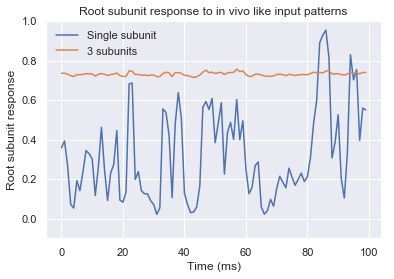

In [ ]:
plt.plot(resp_sing[4900:5000], label="Single subunit")
plt.plot(resp_2[4900:5000], label="3 subunits")
plt.title("Root subunit response to in vivo like input patterns")
plt.xlabel("Time (ms)")
plt.ylabel("Root subunit response")
plt.ylim(bottom=-0.1)
plt.legend()
# plt.savefig("comp_potential.png")
plt.show()

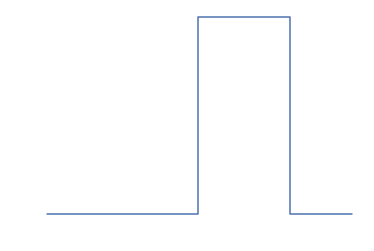

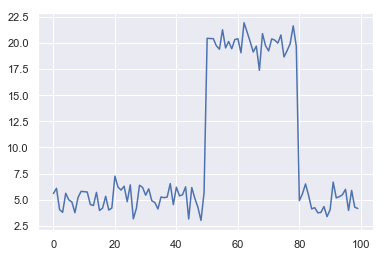

In [ ]:
N=100
states=np.zeros(N)
states[int(N/2):int(0.8*N)]=1
times = np.arange(0, len(states), 1)
plt.step(times, states)
plt.axis("off")
plt.grid(True)
# plt.savefig("states.png")
plt.show()
rates = np.where(states, 20., 5.)
rates += np.random.normal(size=len(states))
plt.plot(times, rates)
# plt.savefig("rates.png")
plt.show()

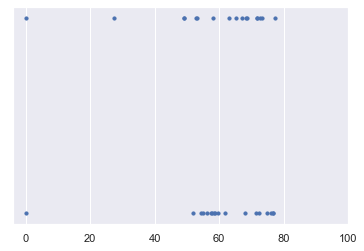

In [ ]:
Erate = [19, 500]
Esd = [2.5, 10]
spt = gen_spikes_states(Tmax=len(rates), N=2, mu=Erate, tau=500, x=states, sd=Esd)
rates = np.where(states, Erate[1], Erate[0])
plt.scatter(spt[:, 1], spt[:, 0]+1, s=10, marker='o')
plt.xlim(right=len(rates))
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
# plt.savefig("events.png")
plt.show()

## Validate functions used in input generation

### Check elevated state durations follow truncated exponential distribution

In [4]:
# first create some states 
Tmax=10000000
st = gen_events_sin(Tmax=Tmax, alpha=20, beta=20, maxL=150)
# then find durations in both up and down state
tt=0 #last transition time
downs=[]
ups=[]
for t in (range(1, Tmax)):
    if st[t] != st[t-1]: #transition has occurred
        dur = t - tt
        if st[t]==1:
            downs.append(dur)
        else:
            ups.append(dur)
        tt = t

100% (9999999 of 9999999) |##############| Elapsed Time: 0:00:17 Time:  0:00:17


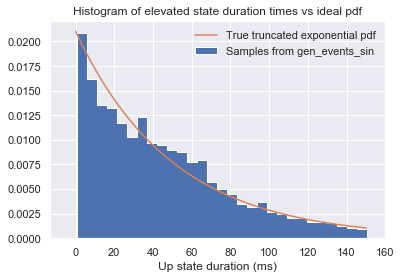

In [5]:
# plot results against actual truncated exponential
times = np.linspace(0, 150, 1000)
# trunc_exp = np.exp(-times)
# trunc_exp = np.clip()
plt.hist(ups, density=True, bins=50, histtype='stepfilled', label="Samples from gen_events_sin")
trunc_exp = np.exp(-0.02 * times)
trunc_exp *= 0.02/(1-np.exp(-0.02*150))
plt.plot(times, trunc_exp, label='True truncated exponential pdf')
plt.xlim(right=160)
plt.xlabel('Up state duration (ms)')
plt.legend()
plt.title("Histogram of elevated state duration times vs ideal pdf")
# plt.savefig("trunc_exp.png")
plt.show()

### Check spiking events follow defined rates

In [2]:
Tmax = 100000
N=100 #number of neurons generating spikes
n_trials=100
rates_high=[]
rates_low=[]

Erate = [5, 20] #firing rate of excitatory inputs for low and high states
Esd = [2.5, 10] #standard deviation of firing rate (for OU process)
for trial in tqdm(range(n_trials)):
    st = gen_events_sin(Tmax=Tmax, alpha=20, beta=20, maxL=150)
    spikes = gen_spikes_states(Tmax=Tmax, N=N, mu=Erate, tau=500, x=st, sd = Esd)
    spike_times = np.floor(spikes[:,1]).astype(int)
    n_low=0
    n_high=0
    for t in spike_times:
        if st[t]==0: #spike produced while neuron in low state
            n_low += 1
        else: #spike produced while neuron in high state
            n_high += 1

    # notional firing rate in Hz
    rate_high = n_high/(np.sum(st) * N) * 1000
    rate_low = n_low/(N*(Tmax - np.sum(st))) * 1000
    
    rates_high.append(rate_high)
    rates_low.append(rate_low)

print('Mean background rate:', np.mean(rates_low), 'Hz', 'Mean elevated rate:', np.mean(rates_high), 'Hz')

100%|██████████| 100/100 [01:18<00:00,  1.29it/s]

Mean background rate: 4.699374152843523 Hz Mean elevated rate: 19.407222585232876 Hz


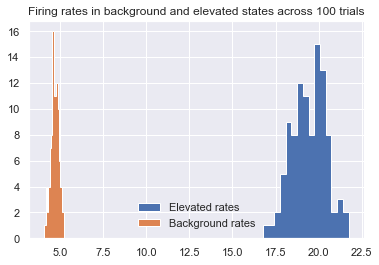

In [15]:
plt.hist(rates_high, density=False, bins=15, histtype='stepfilled', label="Elevated rates")
plt.hist(rates_low, density=False, bins=15, histtype='stepfilled', label="Background rates")
plt.legend()
plt.title(f'Firing rates in background and elevated states across {n_trials} trials')
# plt.savefig('firing_rates_hist.png')
plt.show()